In [1]:
import numpy as np
from matplotlib.lines import Line2D
from expm_mul import expm_multiply
from scipy.sparse.linalg import eigs,norm
from scipy.special import factorial
import matplotlib.pyplot as plt
from fractions import Fraction
from scipy.sparse import csr_matrix,isspmatrix,bmat
import scipy as sci
def get_creation_operator(size,tp):
    return np.diag(np.sqrt(np.arange(1, size),dtype=tp), k=-1)
def get_annihilation_operator(size,tp):
    return np.diag(np.sqrt(np.arange(1, size),dtype=tp), k=1)
def get_s(A,b,tol):
    s=1
    if A.dtype==np.complex256:
        s=np.ceil(_exact_1_norm(A))
    else:
        while(1):
            norm_A = _exact_inf_norm(A)/s
            max_term_notation=np.floor(norm_A)
            max_term=1
            for i in range(1,np.int(max_term_notation)):
                max_term=max_term*norm_A/i
                if max_term >= 10**16:
                    break
            if 10**-16 * max_term <= tol:
                break
            s=s+1
    return s
def _exact_1_norm(A):
    # A compatibility function which should eventually disappear.
    if sci.sparse.isspmatrix(A):
        return max(abs(A).sum(axis=0).flat)
    else:
        return np.linalg.norm(A, 1)
def _expm_multiply_simple_core_global(A, B, tol=None):
    """
    A helper function.
    """
    if tol is None:
        tol =1e-16
    s=get_s(A,B,tol)
    F = B

    c1 = _exact_1_norm(B)
    j=0
    while(1):
        coeff = s*(j+1)
        B =  A.dot(B)/coeff
        c2 = _exact_1_norm(B)
        F = F + B
        total_norm=norm_state(F)
        if (c1+c2)<tol:
            m=j+1
            break
        c1 = c2
        j=j+1
    F =  F
    B = F
    for i in range(1,int(s)):
        c1=c2
        for j in range(m):
            coeff = s*(j+1)
            B =  A.dot(B)/coeff
            F = F + B
        F =  F
        B = F
    return F, m*s
def overnorm(A):
    if A.dtype==np.complex256:
        return _exact_inf_norm(A)
    else:
        return norm_two(A)
def _exact_inf_norm(A):
    # A compatibility function which should eventually disappear.
    if sci.sparse.isspmatrix(A):
        return max(abs(A).sum(axis=1).flat)
    else:
        return np.linalg.norm(A, np.inf)
def norm_two(A):
    if sci.sparse.isspmatrix(A):
        A=csr_matrix(A).conjugate().transpose()
        return np.sqrt(abs(eigs(A=A.dot(A),k=1,which='LM',return_eigenvectors=False)[0]))
    else:
        return np.linalg.norm(A)
def norm_state(A):
    return np.linalg.norm(A)
def block_fre(A,E):
    if isspmatrix(A) is False:
        A = np.block([[A, E], [np.zeros_like(A), A]])
    else:
        A = bmat([[A, E], [None, A]]).tocsc()
    return A
def difference(A,B):
    return overnorm(A-B)/overnorm(A)
def get_H(dim,tp):
    HILBERT_SIZE=dim
    Q_dim=6
    g=0.1*2*np.pi
    anharmonicity =-0.225
    a_dag = get_creation_operator(HILBERT_SIZE,tp)
    a = get_annihilation_operator(HILBERT_SIZE,tp)
    b_dag=get_creation_operator(Q_dim,tp)
    b=get_annihilation_operator(Q_dim,tp)
    A=np.kron(a,np.identity(Q_dim))
    A_dag=np.kron(a_dag,np.identity(Q_dim))
    B=np.kron(np.identity(HILBERT_SIZE),b)
    B_dag=np.kron(np.identity(HILBERT_SIZE),b_dag)
    H_trans = 1 / 2 * anharmonicity * np.dot(np.dot(b_dag, b),np.dot(b_dag,b)-np.identity(Q_dim))
    H0=g*(np.kron(a_dag,b)+np.kron(a,b_dag))+np.kron(np.identity(HILBERT_SIZE),H_trans)
    H=csr_matrix(-1j*(H0+0.5*2*np.pi*(np.dot(B_dag,B)+B+B_dag+1j*(B-B_dag))))
    vec=1/np.sqrt(HILBERT_SIZE*Q_dim)*np.ones(HILBERT_SIZE*Q_dim)
    return H,vec
def get_auxiliary(dim,tp,t):
    HILBERT_SIZE=dim
    Q_dim=6
    g=0.1*2*np.pi
    anharmonicity =-0.225
    a_dag = get_creation_operator(HILBERT_SIZE,tp)
    a = get_annihilation_operator(HILBERT_SIZE,tp)
    b_dag=get_creation_operator(Q_dim,tp)
    b=get_annihilation_operator(Q_dim,tp)
    A=np.kron(a,np.identity(Q_dim))
    A_dag=np.kron(a_dag,np.identity(Q_dim))
    B=np.kron(np.identity(HILBERT_SIZE),b)
    B_dag=np.kron(np.identity(HILBERT_SIZE),b_dag)
    H_trans = 1 / 2 * anharmonicity * np.dot(np.dot(b_dag, b),np.dot(b_dag,b)-np.identity(Q_dim))
    H0=g*(np.kron(a_dag,b)+np.kron(a,b_dag))+np.kron(np.identity(HILBERT_SIZE),H_trans)
    H=csr_matrix(-1j*(H0+0.5*2*np.pi*(np.dot(B_dag,B)+B+B_dag+1j*(B-B_dag))))
    vec=1/np.sqrt(HILBERT_SIZE*Q_dim)*np.ones(2*HILBERT_SIZE*Q_dim)
    vec[0:HILBERT_SIZE*Q_dim]=0
    A=block_fre(t*H,-1j*(B+B_dag))
    return A,vec
def get_norm(ts):
    tp=np.float64()
    anorm=[]
    for i in range(len(ts)):
        HILBERT_SIZE=20
        Q_dim=6
        g=0.1*2*np.pi
        anharmonicity =-0.225
        a_dag = get_creation_operator(HILBERT_SIZE,tp)
        a = get_annihilation_operator(HILBERT_SIZE,tp)
        b_dag=get_creation_operator(Q_dim,tp)
        b=get_annihilation_operator(Q_dim,tp)
        A=np.kron(a,np.identity(Q_dim))
        A_dag=np.kron(a_dag,np.identity(Q_dim))
        B=np.kron(np.identity(HILBERT_SIZE),b)
        B_dag=np.kron(np.identity(HILBERT_SIZE),b_dag)
        H_trans = 1 / 2 * anharmonicity * np.dot(np.dot(b_dag, b),np.dot(b_dag,b)-np.identity(Q_dim))
        H0=g*(np.kron(a_dag,b)+np.kron(a,b_dag))+np.kron(np.identity(HILBERT_SIZE),H_trans)
        H=ts[i]*csr_matrix(-1j*(H0+0.5*2*np.pi*(np.dot(B_dag,B)+B+B_dag+1j*(B-B_dag))))
        anorm.append(norm_two(H))
    return anorm
def get_norm_der(ts):
    tp=np.float64()
    anorm=[]
    for i in range(len(ts)):
        HILBERT_SIZE=20
        Q_dim=6
        g=0.1*2*np.pi
        anharmonicity =-0.225
        a_dag = get_creation_operator(HILBERT_SIZE,tp)
        a = get_annihilation_operator(HILBERT_SIZE,tp)
        b_dag=get_creation_operator(Q_dim,tp)
        b=get_annihilation_operator(Q_dim,tp)
        A=np.kron(a,np.identity(Q_dim))
        A_dag=np.kron(a_dag,np.identity(Q_dim))
        B=np.kron(np.identity(HILBERT_SIZE),b)
        B_dag=np.kron(np.identity(HILBERT_SIZE),b_dag)
        H_trans = 1 / 2 * anharmonicity * np.dot(np.dot(b_dag, b),np.dot(b_dag,b)-np.identity(Q_dim))
        H0=g*(np.kron(a_dag,b)+np.kron(a,b_dag))+np.kron(np.identity(HILBERT_SIZE),H_trans)
        H=csr_matrix(-1j*(H0+0.5*2*np.pi*(np.dot(B_dag,B)+B+B_dag+1j*(B-B_dag))))
        A=ts[i]*block_fre(H,-1j*(A+A_dag))
        anorm.append(norm_two(A))
    return anorm

In [2]:
theta_m=np.array([[8.70950435e-01, 2.48853043e+00, 4.02062662e+00, 5.51075280e+00,
        6.97775212e+00, 8.43027209e+00, 9.87290220e+00, 1.13089234e+01,
        1.27393366e+01, 1.41653119e+01, 1.55887688e+01],
       [1.79283319e-01, 1.30547755e+00, 2.68990434e+00, 4.11674468e+00,
        5.55078449e+00, 6.98409736e+00, 8.41474411e+00, 9.84240944e+00,
        1.12672525e+01, 1.26895571e+01, 1.41096178e+01],
       [0.13,1, 2.2, 3.6,
        4.9, 6.3, 7.7, 9.1,
        11, 12, 1.3],
       [5.87845778e-03, 3.11153531e-01, 1.11496247e+00, 2.19235380e+00,
        3.40348589e+00, 4.68492721e+00, 6.00642014e+00, 7.35228229e+00,
        8.71376145e+00, 1.00856663e+01, 1.14647607e+01],
        [0.003307471010225917,0.24259255239783006,0.9560279579613657,1.9645322216064995,3.1267463661459876,4.372820117778894,5.667919829026178,6.993478543263042,8.338922480962493,9.697877908033124,11.066316441049558 ],
       [2.3e-03, 0.14, 0.64, 1.4,
        2.4, 3.5, 4.7, 6,
        7.2, 8.5, 9.9]])
theta_mm=[]
for j,_theta in enumerate(theta_m):
    a={5:0,10:0,15:0,20:0,25:0,30:0,35:0,40:0,45:0,50:0,55:0}
    for i, theta in enumerate(_theta):
        a[5*(i+1)] = theta
    theta_mm.append(a)

In [6]:
%load_ext line_profiler
tol = 1e-2
dim=120
t=10
H,vec=get_H(dim,np.float64)

a,x1=expm_multiply(t*H, vec, theta_mm[0],tol)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [7]:
print(x1)

1084


In [8]:
%load_ext line_profiler
tol = 1e-2
dim=120
t=10
H,vec=get_H(dim,np.float64)

b,x2=_expm_multiply_simple_core_global(t*H, vec, tol=tol)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [9]:
print(x2)

1309


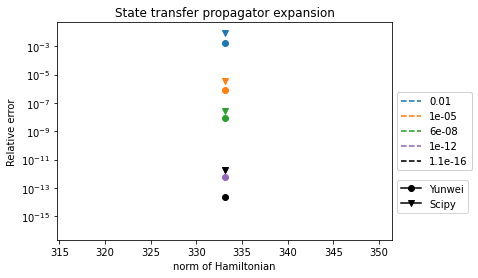

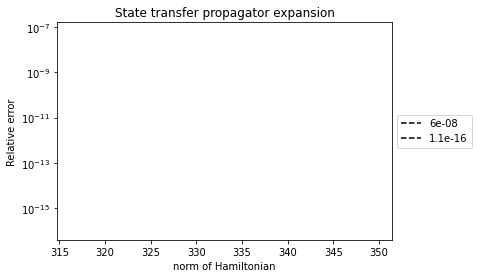

In [120]:
tols=np.array([1e-2,1e-5,2**-24,1e-12,2**-53])
dim=20
ts = np.array([10])
new_error1=np.zeros((len(tols),len(ts)))
new_error=np.zeros((len(tols),len(ts)))
yunwei_ms=np.zeros((len(tols),len(ts)))
sci_ms=np.zeros((len(tols),len(ts)))
for i, t in enumerate(ts):
    H,vec=get_H(dim,np.float64)
    H_st,vec=get_H(dim,np.float128)
    sas_st,x=_expm_multiply_simple_core_global(t*H_st, vec, tol=1e-19)
    for j, tol in enumerate(tols):
        sas,sci_ms[j][i]=expm_multiply(t*H, vec, theta_mm[j],tol)
        new_error1[j][i]=(norm_two(sas-sas_st)/norm_two(sas_st))
for i, t in enumerate(ts):
    H,vec=get_H(dim,np.float64)
    H_st,vec=get_H(dim,np.float128)
    sas_st,x=_expm_multiply_simple_core_global(t*H_st, vec, tol=1e-19)
    for j, tol in enumerate(tols):
        sas,yunwei_ms[j][i]=_expm_multiply_simple_core_global(t*H, vec, tol=tol)
        new_error[j][i]=(norm_two(sas-sas_st)/norm_two(sas_st))


norm = get_norm(ts)
tols=np.array([1e-2,1e-5,6.0e-8,1e-12,1.1e-16])
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
color = ['tab:blue','tab:orange','tab:green','tab:purple','k']

legend_elements = [Line2D([0], [0], marker='o', color='k', label='Yunwei',)
                          ,
                  Line2D([0], [0], marker='v', color='k', label='Scipy',)
                          , ]
for i in range(len(new_error1)):
    ax.plot(norm,new_error[i],color = color[i],marker='o')
    ax.plot(norm,new_error1[i],color = color[i],marker='v')
    ax.plot(norm,tols[i]*np.ones(len(new_error1[i])),'--',color=color[i], label= str(tols[i]))
ax.set_yscale('log')
legend2=ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
legend1=ax.legend(handles=legend_elements,loc='center left', bbox_to_anchor=(1, 0.2))
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.set_yscale('log')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('norm of Hamiltonian')
ax.set_ylabel('Relative error')
ax.set_title('State transfer propagator expansion')
fig.savefig('State_propagator_0.pdf',bbox_inches='tight')

fig,ax = plt.subplots()
color = ['r','b']
i=2
ax.plot(norm,new_error[i],color = 'b')
ax.plot(norm,new_error1[i],color = 'r')
ax.plot(norm,tols[i]*np.ones(len(new_error1[0])),'--',color='k', label= str(tols[2]))
i=4
ax.plot(norm,new_error[i],color = 'b')
ax.plot(norm,new_error1[i],color = 'r')
ax.plot(norm,tols[i]*np.ones(len(new_error1[1])),'--',color='k', label= str(tols[4]))

ax.set_yscale('log')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('norm of Hamiltonian')
ax.set_ylabel('Relative error')
ax.set_title('State transfer propagator expansion')
fig.savefig('State_propagator_1.pdf',bbox_inches='tight')

In [121]:
yunwei_ms/sci_ms

array([[1.280437756497948 ],
       [1.2223515715948778],
       [1.1578421578421578],
       [1.4158163265306123],
       [3.610566037735849 ]])

In [56]:
new_error1/new_error

array([[  4.2583898147541   ,   3.9248280438761163,   5.142588262285965 ,
          5.333973948415277 ,   5.451278656079942 ,  10.518107566314274 ,
          6.335914322613925 ,   3.842014792218632 ,   5.5708989026830436],
       [  9.80300643550652  ,   4.184992537745195 ,   4.692658388109061 ,
          4.49493741500677  ,   3.3027167033913014,   4.7678404654679465,
          3.198305461676118 ,   4.480928113121063 ,   1.616937762669741 ],
       [  3.348806715033725 ,   2.849714136348464 ,   3.263404763099385 ,
          4.701456174574618 ,   4.700730125790232 ,   1.8902070607991974,
          1.861219688259493 ,   6.70372903708278  ,   1.9957141523575714],
       [  1.31139451067256  ,   1.3331637416661355,   1.1342261976925725,
          2.2897507964530757,   1.4086015582460663,   1.7328284413029273,
          2.9302313836348595,   2.023527437616957 ,   1.9376884038936528],
       [  6.39774041526096  ,  32.39175062112459  , 188.06816179050054  ,
         74.82818584575509  ,  60.

[-8.648899195918716790e-05-9.132761355124091264e-02j
 -2.387191301714155786e-04-2.204566172901035599e-01j
 -4.823734954103590619e-04-2.872716929012948100e-01j
 -7.328244838856553526e-04-3.407452726235110926e-01j
 -8.370910745710667293e-04-3.865979937927516944e-01j
 -5.631824728936069512e-04-2.039951983807290848e-01j
 -9.866148091097531349e-05-9.132760150782644532e-02j
 -2.649452024355697088e-04-2.204565786864537446e-01j
 -5.258941427750016314e-04-2.872716127242539857e-01j
 -7.926801297601755565e-04-3.407451555462746053e-01j
 -8.818099627239122711e-04-3.865978786546640914e-01j
 -5.940684021198862274e-04-2.039951278075598348e-01j
 -1.041232198745927875e-04-9.132759512085147473e-02j
 -2.770675379664359752e-04-2.204565581055344157e-01j
 -5.472061083846060381e-04-2.872715696942001778e-01j
 -8.224658200816996134e-04-3.407450920996185657e-01j
 -9.070149365697223493e-04-3.865978107372361780e-01j
 -6.127088715226485239e-04-2.039950832149018454e-01j
 -1.083832154157457899e-04-9.13275901164244778

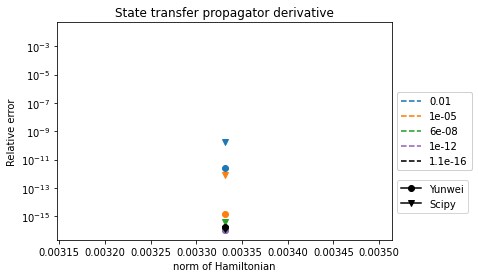

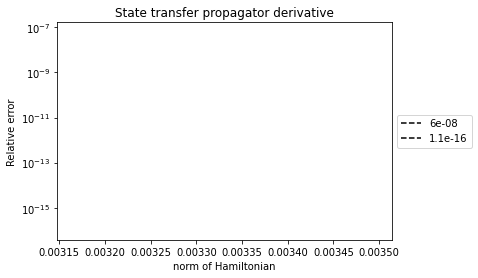

In [73]:
tols=np.array([1e-2,1e-5,2**-24,1e-12,2**-53])
dim=20
ts = np.array([1,2,3,4,5,6,7,8,9,10])
new_error1=np.zeros((len(tols),len(ts)))
new_error=np.zeros((len(tols),len(ts)))
yunwei_ms=np.zeros((len(tols),len(ts)))
sci_ms=np.zeros((len(tols),len(ts)))
for i, t in enumerate(ts):
    H,vec=get_auxiliary(dim,np.float64,t)
    H_st,vec=get_auxiliary(dim,np.float128,t)
    
    sas_st,x=_expm_multiply_simple_core_global(H_st, vec, tol=1e-19)
    for j, tol in enumerate(tols):
        sas,sci_ms[j][i]=expm_multiply(H, vec, theta_mm[j],tol)

        new_error1[j][i]=(norm_two(sas-sas_st)/norm_two(sas_st))
for i, t in enumerate(ts):
    H,vec=get_auxiliary(dim,np.float64,t)
    H_st,vec=get_auxiliary(dim,np.float128,t)
    sas_st,x=_expm_multiply_simple_core_global(H_st, vec, tol=1e-19)
    for j, tol in enumerate(tols):
        sas,yunwei_ms[j][i]=_expm_multiply_simple_core_global(H, vec, tol=tol)
        new_error[j][i]=(norm_two(sas-sas_st)/norm_two(sas_st))

norm = get_norm(ts)
tols=np.array([1e-2,1e-5,6.0e-8,1e-12,1.1e-16])
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
color = ['tab:blue','tab:orange','tab:green','tab:purple','k']

legend_elements = [Line2D([0], [0], marker='o', color='k', label='Yunwei',)
                          ,
                  Line2D([0], [0], marker='v', color='k', label='Scipy',)
                          , ]
for i in range(len(new_error1)):
    ax.plot(norm,new_error[i],color = color[i],marker='o')
    ax.plot(norm,new_error1[i],color = color[i],marker='v')
    ax.plot(norm,tols[i]*np.ones(len(new_error1[i])),'--',color=color[i], label= str(tols[i]))
ax.set_yscale('log')
legend2=ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
legend1=ax.legend(handles=legend_elements,loc='center left', bbox_to_anchor=(1, 0.2))
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.set_yscale('log')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('norm of Hamiltonian')
ax.set_ylabel('Relative error')
ax.set_title('State transfer propagator derivative')
fig.savefig('State_propagator_der_0.pdf',bbox_inches='tight')
fig,ax = plt.subplots()
color = ['r','b']
i=2
ax.plot(norm,new_error[i],color = 'b')
ax.plot(norm,new_error1[i],color = 'r')
ax.plot(norm,tols[i]*np.ones(len(new_error1[0])),'--',color='k', label= str(tols[2]))
i=4
ax.plot(norm,new_error[i],color = 'b')
ax.plot(norm,new_error1[i],color = 'r')
ax.plot(norm,tols[i]*np.ones(len(new_error1[1])),'--',color='k', label= str(tols[4]))

ax.set_yscale('log')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('norm of Hamiltonian')
ax.set_ylabel('Relative error')
ax.set_title('State transfer propagator derivative')
fig.savefig('State_propagator_der_1.pdf',bbox_inches='tight')

In [59]:
yunwei_ms/sci_ms

array([[1.25              , 1.2               , 1.28              ,
        1.2881355932203389, 1.2970027247956404, 1.290909090909091 ,
        1.2734225621414914, 1.2773109243697478, 1.281391830559758 ,
        1.2897959183673469],
       [1.0980392156862746, 1.1978609625668448, 1.2075471698113207,
        1.2616279069767442, 1.2279069767441861, 1.2403100775193798,
        1.2262895174708819, 1.229985443959243 , 1.2315653298835705,
        1.2223515715948778],
       [1.233644859813084 , 1.2               , 1.1842105263157894,
        1.1597051597051597, 1.1706349206349207, 1.1644736842105263,
        1.1666666666666667, 1.1654135338345866, 1.1750278706800446,
        1.1498015873015872],
       [1.3194444444444444, 1.2647058823529411, 1.4098360655737705,
        1.4180672268907564, 1.3979933110367893, 1.4273624823695346,
        1.3945172824791419, 1.4285714285714286, 1.4166666666666667,
        1.4110169491525424],
       [3.206060606060606 , 3.513888888888889 , 3.6552567237163816,


In [60]:
new_error1/new_error

array([[ 12.324016941929575 ,   8.564466144704486 ,  26.00876159552229  ,
          9.735698233197569 ,   5.820951337951608 ,   5.1612402653902665,
         16.563369678686527 ,  10.422680025013594 ,   7.293914783316375 ,
          6.30979509558151  ],
       [  9.052463593834569 ,  16.323659890187336 ,   4.327713055949413 ,
          9.0386824387284   ,   3.426116655833134 ,   4.6270102211834505,
          3.211977566965951 ,   2.8513861097011213,   5.230601877369074 ,
          4.574991168206514 ],
       [  1.9820021607322593,   9.809825354225842 ,  11.264994462362159 ,
          4.635855081552929 ,   2.8969869905746766,   3.669197721118601 ,
          4.466232773900226 ,   7.275515294555044 ,   7.361967967216601 ,
          1.7625532763051572],
       [  0.6279961922417907,   0.5300272099268397,   2.79137603262567  ,
          1.8811981810332674,   2.8321163136844976,   2.8092980301769077,
          1.838565639075191 ,   1.9106426413162205,   1.9702247544318876,
          2.5390489

In [74]:
from qutip import qload
import numpy as np
from scipy.sparse.linalg import eigs
from scipy.special import factorial
import matplotlib.pyplot as plt
from scipy.sparse import dia_matrix,identity
from fractions import Fraction
from scipy.sparse import csr_matrix,isspmatrix,bmat,kron
import scipy as sci
from scipy.sparse import csr_matrix,isspmatrix,bmat
def get_creation_operator(size,tp):
    return np.diag(np.sqrt(np.arange(1, size),dtype=tp), k=-1)
def get_annihilation_operator(size,tp):
    return np.diag(np.sqrt(np.arange(1, size),dtype=tp), k=1)
def get_norm(dim):
    tp=np.float64
    anorm=[]
    for i in range(len(dim)):
        N=7
        control=get_control(N,tp)
        control_pra=0.5*2*np.pi*np.ones(np.array(control).shape[0])
        H_control=control_H(control_pra,control)
        H=H_control+get_int(N,tp)
        anorm.append(overnorm(dim[i]*H))
    return anorm
def get_norm_der(dim):
    tp=np.float64
    anorm=[]
    for i in range(len(dim)):
        N=7
        control=get_control(N,tp)
        control_pra=0.5*2*np.pi*np.ones(np.array(control).shape[0])
        H_control=control_H(control_pra,control)
        H=H_control+get_int(N,tp)
        vec=1/np.sqrt(2*2**N)*np.identity(2*2**N)
        A=block_fre(H,-1j*(control[0]))
        anorm.append(overnorm(dim[i]*A))
    return anorm
def get_auxiliary(N,tp,t):
    control=get_control(N,tp)
    H,vec = get_H(N,tp)
    vec=1/np.sqrt(2**N)*np.ones(2*2**N)
    vec[0:2**N]=0
    A=block_fre(t*H,-1j*(control[3]))
    return A,vec
def get_int(N,tp):
    sigmap=get_creation_operator(2,tp)
    sigmam = get_annihilation_operator(2,tp)
    sigmaz=sigmap.dot(sigmam)
    H0=0
    SIGMAZ=kron(sigmaz,sigmaz)
    H0=H0+kron(SIGMAZ,identity(2**(N-2)))+kron(identity(2**(N-2)),SIGMAZ)
    for i in range(1,N-2):
        H0=H0+kron(kron(identity(2**i),SIGMAZ),identity(2 ** (N - 2 - i)))
    return H0
def get_control(N,tp):
    sigmap=get_creation_operator(2,tp)
    sigmam = get_annihilation_operator(2,tp)
    sigmap=sigmap
    sigmam=sigmam
    sigmax=sigmap+sigmam
    sigmay=-1j*sigmap+1j*sigmam
    control=[]
    if N==1:
        control.append(kron(sigmax, identity(2 ** (N - 1))))
        control.append(kron(sigmay, identity(2 ** (N - 1))))
        return control
    else:
        a=identity(2**(N-1))
        control.append(kron(sigmax,a,format="csc"))
        control.append(kron(sigmay, identity(2 ** (N - 1)),format="csc"))
        for i in range(1,N-1):
            control.append(kron(kron(identity(2**i),sigmax), identity(2 ** (N - 1-i)),format="csc"))
            control.append(kron(kron(identity(2 ** i), sigmay), identity(2 ** (N - 1 - i)),format="csc"))
        control.append(kron(identity(2**(N-1)),sigmax,format="csc"))
        control.append(kron(identity(2**(N-1)),sigmay,format="csc"))
    return control
def control_H(control,H_control):
    H=0
    for i in range(len(control)):
        H=H+control[i]*H_control[i]
    return H
def get_H(N,tp):
    control=get_control(N,tp)
    control_pra=0.5*2*np.pi*np.ones(np.array(control).shape[0])
    H_control=control_H(control_pra,control)
    H=-1j*(H_control+get_int(N,tp)*0.1*2*np.pi)
    vec=1/np.sqrt(2**N)*np.ones(2**N)
    return H,vec


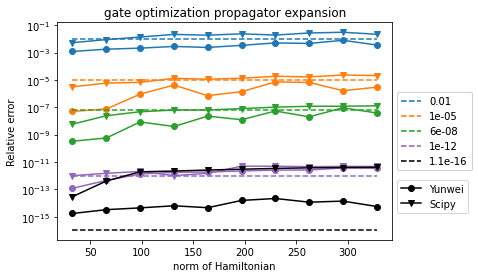

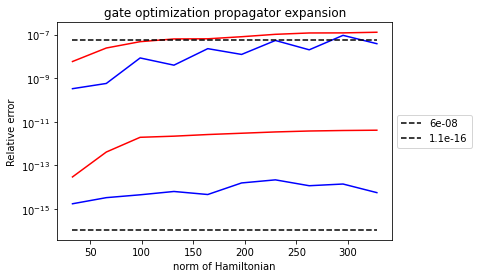

In [82]:
dim=7
tols=np.array([1e-2,1e-5,2**-24,1e-12,2**-53])
ts = np.array([1,2,3,4,5,6,7,8,9,10])
new_error1=np.zeros((len(tols),len(ts)))
new_error=np.zeros((len(tols),len(ts)))
yunwei_ms=np.zeros((len(tols),len(ts)))
sci_ms=np.zeros((len(tols),len(ts)))
for i, t in enumerate(ts):
    H,vec=get_H(dim,np.float64)
    H_st,vec=get_H(dim,np.float128)
    
    sas_st,x=_expm_multiply_simple_core_global(t*H_st, vec, tol=1e-19)
    for j, tol in enumerate(tols):
        sas,sci_ms[j][i]=expm_multiply(t*H, vec, theta_mm[j],tol)

        new_error1[j][i]=(norm_two(sas-sas_st)/norm_two(sas_st))
for i, t in enumerate(ts):
    H,vec=get_H(dim,np.float64)
    H_st,vec=get_H(dim,np.float128)
    sas_st,x=_expm_multiply_simple_core_global(t*H_st, vec, tol=1e-19)
    for j, tol in enumerate(tols):
        sas,yunwei_ms[j][i]=_expm_multiply_simple_core_global(t*H, vec, tol=tol)
        new_error[j][i]=(norm_two(sas-sas_st)/norm_two(sas_st))

norm = get_norm(ts)
tols=np.array([1e-2,1e-5,6.0e-8,1e-12,1.1e-16])
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
color = ['tab:blue','tab:orange','tab:green','tab:purple','k']


legend_elements = [Line2D([0], [0], marker='o', color='k', label='Yunwei',)
                          ,
                  Line2D([0], [0], marker='v', color='k', label='Scipy',)
                          , ]
for i in range(len(new_error1)):
    ax.plot(norm,new_error[i],color = color[i],marker='o')
    ax.plot(norm,new_error1[i],color = color[i],marker='v')
    ax.plot(norm,tols[i]*np.ones(len(new_error1[i])),'--',color=color[i], label= str(tols[i]))
ax.set_yscale('log')
legend2=ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
legend1=ax.legend(handles=legend_elements,loc='center left', bbox_to_anchor=(1, 0.2))
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.set_yscale('log')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('norm of Hamiltonian')
ax.set_ylabel('Relative error')
ax.set_title('gate optimization propagator expansion')
fig.savefig('gate_propagator_0.pdf',bbox_inches='tight')

fig,ax = plt.subplots()
color = ['r','b']
i=2
ax.plot(norm,new_error[i],color = 'b')
ax.plot(norm,new_error1[i],color = 'r')
ax.plot(norm,tols[i]*np.ones(len(new_error1[0])),'--',color='k', label= str(tols[2]))
i=4
ax.plot(norm,new_error[i],color = 'b')
ax.plot(norm,new_error1[i],color = 'r')
ax.plot(norm,tols[i]*np.ones(len(new_error1[1])),'--',color='k', label= str(tols[4]))

ax.set_yscale('log')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('norm of Hamiltonian')
ax.set_ylabel('Relative error')
ax.set_title('gate optimization propagator expansion')
fig.savefig('gate_propagator_1.pdf',bbox_inches='tight')

In [83]:
yunwei_ms/sci_ms

array([[1.                , 1.0337078651685394, 1.037593984962406 ,
        1.005464480874317 , 1.055045871559633 , 1.0356472795497185,
        1.0522875816993464, 1.0439716312056737, 1.0507614213197969,
        1.0502283105022832],
       [0.9166666666666666, 1.024390243902439 , 1.0098360655737706,
        0.9551886792452831, 1.001934235976789 , 1.0098360655737706,
        1.0042372881355932, 0.9574468085106383, 0.9946178686759957,
        1.0098328416912488],
       [0.9833333333333333, 0.9957805907172996, 0.96045197740113  ,
        0.9639830508474576, 0.9459459459459459, 0.9577464788732394,
        0.9443772672309553, 0.9492063492063492, 0.9464788732394366,
        0.9459459459459459],
       [1.2112676056338028, 1.1625441696113075, 1.1320754716981132,
        1.0945017182130585, 1.0828729281767955, 1.135005973715651 ,
        1.1270491803278688, 1.1230907457322552, 1.1137629276054097,
        1.1079342387419586],
       [3.8461538461538463, 2.5964391691394657, 2.771966527196653 ,


In [84]:
new_error1/new_error

array([[4.3713053385484590e+00, 5.0417541994282855e+00,
        6.4752309339878646e+00, 7.5981421144378771e+00,
        7.8795420146888029e+00, 6.9516225735143538e+00,
        3.7470783709687638e+00, 5.8094911046485453e+00,
        3.8898269178841680e+00, 6.0917494074167164e+00],
       [6.2593234229590365e+01, 7.8340691904370345e+01,
        7.2098809450542864e+00, 3.1229673541985195e+00,
        1.6133815321058872e+01, 9.5135901174242612e+00,
        2.6031099007748875e+00, 2.5332481698232194e+00,
        1.4076364121814507e+01, 7.0641154438411551e+00],
       [1.7667111966266301e+01, 4.2355029812629745e+01,
        5.5861175475056148e+00, 1.5968661393460881e+01,
        2.8342290990277483e+00, 6.4969059076305467e+00,
        1.9176613968482024e+00, 5.9242105318994147e+00,
        1.2965488268962257e+00, 3.3556890709531078e+00],
       [8.3152664476071649e+00, 3.3668606442899351e+00,
        1.5260294819384934e+00, 5.8282407857125029e-01,
        8.0305205805648594e-01, 2.23915842405

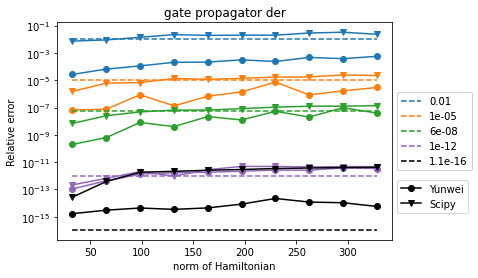

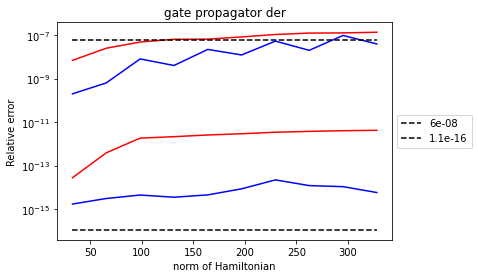

In [85]:
dim=7
ts = np.array([1,2,3,4,5,6,7,8,9,10])
new_error1=np.zeros((len(tols),len(ts)))
new_error=np.zeros((len(tols),len(ts)))
yunwei_ms=np.zeros((len(tols),len(ts)))
sci_ms=np.zeros((len(tols),len(ts)))
for i, t in enumerate(ts):
    H,vec=get_auxiliary(dim,np.float64,t)
    H_st,vec=get_auxiliary(dim,np.float128,t)
    
    sas_st,x=_expm_multiply_simple_core_global(H_st, vec, tol=1e-19)
    for j, tol in enumerate(tols):
        sas,sci_ms[j][i]=expm_multiply(H, vec, theta_mm[j],tol)

        new_error1[j][i]=(norm_two(sas-sas_st)/norm_two(sas_st))
for i, t in enumerate(ts):
    H,vec=get_auxiliary(dim,np.float64,t)
    H_st,vec=get_auxiliary(dim,np.float128,t)
    sas_st,x=_expm_multiply_simple_core_global(H_st, vec, tol=1e-19)
    for j, tol in enumerate(tols):
        sas,yunwei_ms[j][i]=_expm_multiply_simple_core_global(H, vec, tol=tol)
        new_error[j][i]=(norm_two(sas-sas_st)/norm_two(sas_st))
        
norm = get_norm(ts)
tols=np.array([1e-2,1e-5,6.0e-8,1e-12,1.1e-16])
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
color = ['tab:blue','tab:orange','tab:green','tab:purple','k']

legend_elements = [Line2D([0], [0], marker='o', color='k', label='Yunwei',)
                          ,
                  Line2D([0], [0], marker='v', color='k', label='Scipy',)
                          , ]
for i in range(len(new_error1)):
    ax.plot(norm,new_error[i],color = color[i],marker='o')
    ax.plot(norm,new_error1[i],color = color[i],marker='v')
    ax.plot(norm,tols[i]*np.ones(len(new_error1[i])),'--',color=color[i], label= str(tols[i]))
ax.set_yscale('log')
legend2=ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
legend1=ax.legend(handles=legend_elements,loc='center left', bbox_to_anchor=(1, 0.2))
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.set_yscale('log')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('norm of Hamiltonian')
ax.set_ylabel('Relative error')
ax.set_title('gate propagator der')
fig.savefig('gate_propagator_der_0.pdf',bbox_inches='tight')

fig,ax = plt.subplots()
color = ['r','b']
i=2
ax.plot(norm,new_error[i],color = 'b')
ax.plot(norm,new_error1[i],color = 'r')
ax.plot(norm,tols[i]*np.ones(len(new_error1[0])),'--',color='k', label= str(tols[2]))
i=4
ax.plot(norm,new_error[i],color = 'b')
ax.plot(norm,new_error1[i],color = 'r')
ax.plot(norm,tols[i]*np.ones(len(new_error1[1])),'--',color='k', label= str(tols[4]))

ax.set_yscale('log')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('norm of Hamiltonian')
ax.set_ylabel('Relative error')
ax.set_title('gate propagator der')
fig.savefig('gate_propagator_der_1.pdf',bbox_inches='tight')

In [86]:
yunwei_ms/sci_ms

array([[1.                , 1.0786516853932584, 1.0676691729323309,
        1.0245901639344261, 1.073394495412844 , 1.0707456978967496,
        1.0718954248366013, 1.0595744680851065, 1.0659898477157361,
        1.067351598173516 ],
       [1.0185185185185186, 1.024390243902439 , 1.0098360655737706,
        0.9905660377358491, 1.001934235976789 , 1.0098360655737706,
        0.9806896551724138, 0.975177304964539 , 0.9946178686759957,
        1.0098328416912488],
       [1.                , 0.9957805907172996, 0.96045197740113  ,
        0.9788135593220338, 0.9459459459459459, 0.9577464788732394,
        0.9443772672309553, 0.9492063492063492, 0.9464788732394366,
        0.9459459459459459],
       [1.0232558139534884, 1.104026845637584 , 1.1320754716981132,
        1.0945017182130585, 1.1073446327683616, 1.135005973715651 ,
        1.1270491803278688, 1.1230907457322552, 1.1137629276054097,
        1.1079342387419586],
       [3.8461538461538463, 2.6706231454005933, 2.771966527196653 ,


In [87]:
new_error1/new_error

array([[2.7155317941258681e+02, 1.3744552756995191e+02,
        1.2373877439308076e+02, 1.0686251139634598e+02,
        8.9480403737741028e+01, 6.4638728338153498e+01,
        8.4003176834577587e+01, 6.1162922066288957e+01,
        8.5665227090018277e+01, 4.1293746486926267e+01],
       [2.3053470355485448e+01, 7.9891095906768697e+01,
        7.7893997211850738e+00, 1.0089195673219581e+02,
        1.7223572672833342e+01, 9.9443009337438344e+00,
        2.3326897125761823e+00, 2.0744355572240067e+01,
        1.4608364526336103e+01, 7.5241914351701453e+00],
       [3.4577729150575934e+01, 3.9322687125114946e+01,
        5.9784850438412631e+00, 1.6047194833341049e+01,
        2.9778694379975841e+00, 6.7522788040318824e+00,
        2.0149323960747658e+00, 6.2234918321362018e+00,
        1.3079454363632943e+00, 3.4569122701837975e+00],
       [1.9613444360494356e+00, 1.5184942118212463e+00,
        1.5302471136015612e+00, 5.6568832869400987e-01,
        1.5342862455277253e+00, 2.24503068522